# <a id='toc1_'></a>[Introduction and objective](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Introduction and objective](#toc1_)    
- [Importing and defining data](#toc2_)    
- [Functions we used](#toc3_)    
  - [Test cases of what we have used](#toc3_1_)    
- [Creating a workflow object](#toc4_)    
  - [Initial tests](#toc4_1_)    
  - [Changing Scale](#toc4_2_)    
- [Creating the object to clean structures](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This is the unit testing of the cleaning structures code. As we advanced further and further down the cleaning steps, we did not carefully checked the functions to clean the salts, neutralize and turn it into canonical structures. 

The main objective here is to translate it into a function (or object) so we can already perform it into another structures and also to give it to lab's partners so they incorporate it into their workflow for cleaning a bunch of ligands. 

# <a id='toc2_'></a>[Importing and defining data](#toc0_)

In [1]:
import pandas as pd
import session_info

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import rdmolops # To clean the structures
from IPython.display import HTML

# Defining a function to print all structures in mol correctly
def show_df(df):
    return HTML(df.to_html(notebook=True))

Below we define some test cases so we can how we have dealt with each case:

In [2]:
test_cases = {
    "SMILES": [
        'C[C@@H](CC1=CC=CC=C1)N.Cl',
        'C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O.[Na+].[Na+].[Na+] ',
        'COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=CC=CO4)N)OC.Cl',
        'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl.OP(=O)(O)O.OP(=O)(O)O ',
        'C[S+](C)[O-]',
        'CC(C(=O)[O-])O',
        'C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C',
        'CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C',
        'C1=CC=C2C(=C1)C(=O)NS2(=O)=O',
        'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C',
        'C#CCNC1CCC2=CC=CC=C12',
        'CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC',
        'CN1C(=C(C2=C(S1(=O)=O)C=CS2)O)C(=O)NC3=CC=CC=N3',
        'CN1C(C(=O)Nc2ccccn2)C(=O)c3sccc3[S]1(=O)=O',
        'Sc1ncnc2nc[nH]c12',
        'S=c1[nH]cnc2nc[nH]c12',
    ],
    "NAME": [
        'DEXTROAMPHETAMINE HYDROCHLORIDE',
        'SODIUM CITRATE',
        'PRAZOSIN HYDROCHLORIDE',
        'CHLOROQUINE DIPHOSPHATE',
        'DIMETHYL SULFOXIDE',
        'LACTATE',
        'DECAMETHONIUM',
        'DIHYDROTESTOSTERONE',
        'SACCHARIN',
        'BETACAROTENE',
        'RASAGILINE',
        'COCAINE',
        'TENOXICAM',
        'TENOXICAM',
        'MERCAPTOPURINE',
        'MERCAPTOPURINE',
    ],
    "CASE": [
        'STEREOCHEMISTRY',
        'MULTIPLE SALT',
        'SIMPLE SALT',
        'COMPLEX SALT',
        'POSITIVE/NEGATIVE',
        'NEGATIVE',
        'POSITIVE',
        'SINGLE',
        'DOUBLE',
        'ALTERNATING DOUBLE',
        'TRIPLE',
        'BRIDGE ATOMS',
        'TAUTORMER A',
        'TAUTOMER A',
        'TAUTOMER B',
        'TAUTOMER B',
    ],
}

# Transforming it into a dataframe
test_cases_df = pd.DataFrame.from_dict(test_cases)
test_cases_df.head(10)

,SMILES,NAME,CASE
0,C[C@@H](CC1=CC=CC=C1)N.Cl,DEXTROAMPHETAMINE HYDROCHLORIDE,STEREOCHEMISTRY
1,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O.[Na+].[N...,SODIUM CITRATE,MULTIPLE SALT
2,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=C...,PRAZOSIN HYDROCHLORIDE,SIMPLE SALT
3,CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl.OP(=O)(...,CHLOROQUINE DIPHOSPHATE,COMPLEX SALT
4,C[S+](C)[O-],DIMETHYL SULFOXIDE,POSITIVE/NEGATIVE
5,CC(C(=O)[O-])O,LACTATE,NEGATIVE
6,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,DECAMETHONIUM,POSITIVE
7,CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C,DIHYDROTESTOSTERONE,SINGLE
8,C1=CC=C2C(=C1)C(=O)NS2(=O)=O,SACCHARIN,DOUBLE
9,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,BETACAROTENE,ALTERNATING DOUBLE


# <a id='toc3_'></a>[Functions we used](#toc0_)

In [3]:
# Salt Cleaning by Keeping the Largest Fragment
# Usar a funcao do rdkit para limpar sal (talvez?)
def keep_largest_fragment(mol):
    '''
    This function reads a mol object and returns the largest fragment, as mol
    '''
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

def neutralize_standardize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]

    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return Chem.MolToSmiles(mol) # Isso aqui já canoniza os SMILES?

def smiles_to_inchi(smiles:str) -> str:
    """
    This function recieves a smiles string, and uses openbabel (in linux terminal, be aware of openbabel dependency) to convert it to InChI
    """
    response = ! obabel -:"{smiles}" -oinchi
    return response[-2]

## <a id='toc3_1_'></a>[Test cases of what we have used](#toc0_)

,CASE,before_cleaning,after_cleaning
0,STEREOCHEMISTRY,,
1,MULTIPLE SALT,,
2,SIMPLE SALT,,
3,COMPLEX SALT,,
4,POSITIVE/NEGATIVE,,
5,NEGATIVE,,
6,POSITIVE,,
7,SINGLE,,
8,DOUBLE,,
9,ALTERNATING DOUBLE,,

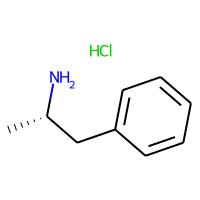
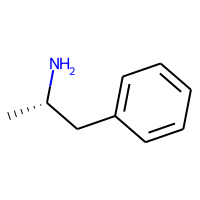
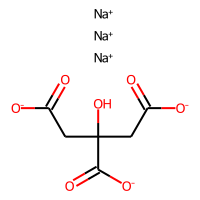
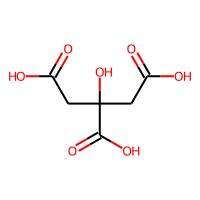
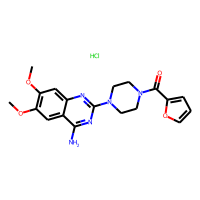
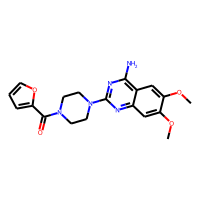
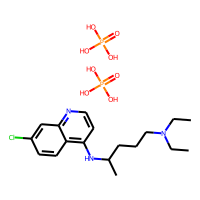
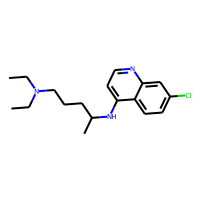
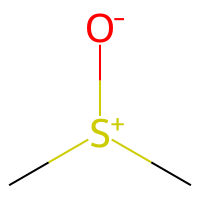
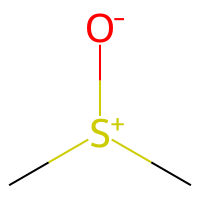
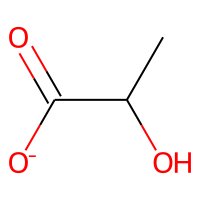
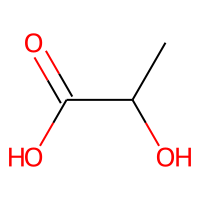
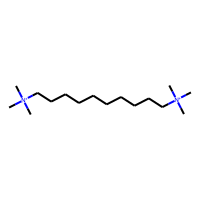
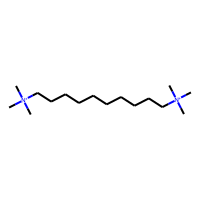
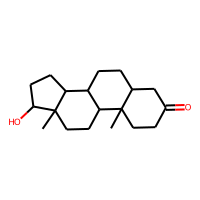
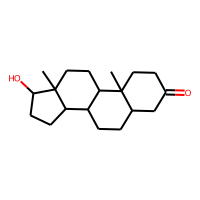
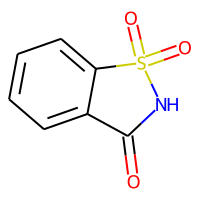
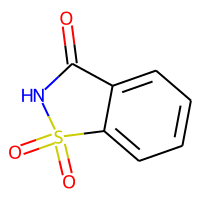
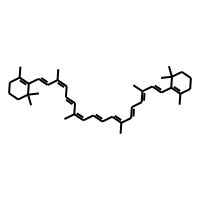
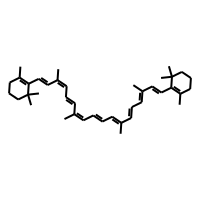
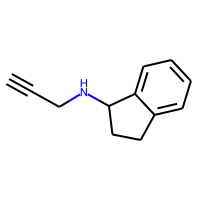
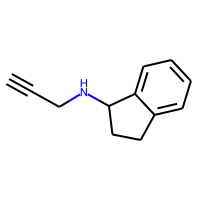
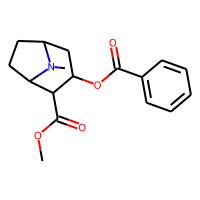
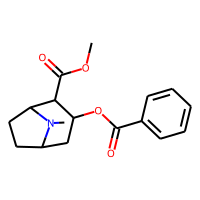
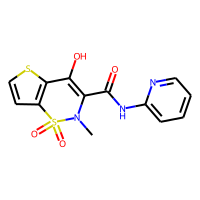
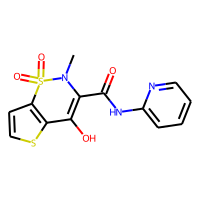
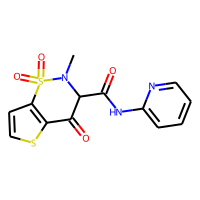
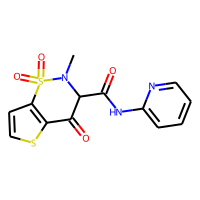
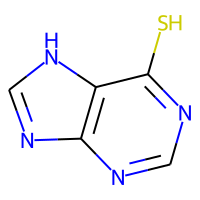
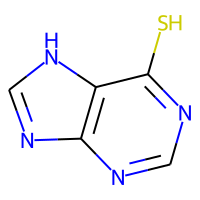

In [4]:
# Before cleaning the SMILES
PandasTools.AddMoleculeColumnToFrame(smilesCol='SMILES', molCol='before_cleaning', frame=test_cases_df)

# Keeping largest fragment
test_cases_df['cleaned_smiles'] = test_cases_df['before_cleaning'].apply(keep_largest_fragment)
# Neutralizing atoms
test_cases_df['cleaned_smiles'] = test_cases_df['cleaned_smiles'].apply(neutralize_standardize_atoms)

# Create smiles to inchi column
test_cases_df['InChI_from_smiles'] = test_cases_df['cleaned_smiles'].apply(smiles_to_inchi)

# Generating the final MOL
PandasTools.AddMoleculeColumnToFrame(smilesCol='cleaned_smiles', molCol='after_cleaning', frame=test_cases_df)

# Dropping one of the duplicates
test_cases_df.drop_duplicates(subset=['InChI_from_smiles'], inplace=True)
test_cases_df.drop(columns=['SMILES', 'NAME','cleaned_smiles', 'InChI_from_smiles'], inplace=True)
test_cases_df

# <a id='toc4_'></a>[Creating a workflow object](#toc0_)

Now we can create a workflow using OOP notation to perform all these tasks, but first we need to test some pre-built function for:
* Cleaning the salts - (SaltRemover)
* Calculating the InChI (using RDKit)

## <a id='toc4_1_'></a>[Initial tests](#toc0_)

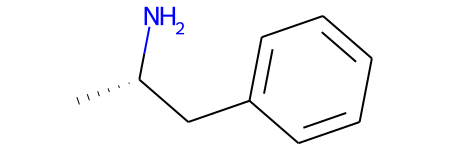

In [5]:
# Testing SaltRemover
remover = SaltRemover()
dexamphetamine = Chem.MolFromSmiles('C[C@@H](CC1=CC=CC=C1)N.Cl')
res = remover.StripMol(dexamphetamine, dontRemoveEverything=True)
res

In [6]:
# Testing Tautomers/Duplicates
# Mercaptopurine 1
m1 = Chem.MolFromSmiles('Sc1ncnc2nc[nH]c12')
m1_inchi = Chem.MolToInchi(m1)

# Mercaptopurine 2
m2 = Chem.MolFromSmiles('S=c1[nH]cnc2nc[nH]c12')
m2_inchi = Chem.MolToInchi(m2)

print(m1_inchi == m2_inchi)

True


## <a id='toc4_2_'></a>[Changing Scale](#toc0_)

,SMILES,RAW_MOL,CASE
0,C[C@@H](CC1=CC=CC=C1)N.Cl,,STEREOCHEMISTRY
1,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O.[Na+].[N...,,MULTIPLE SALT
2,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=C...,,SIMPLE SALT

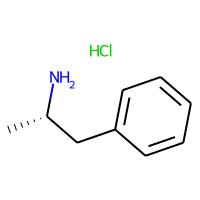
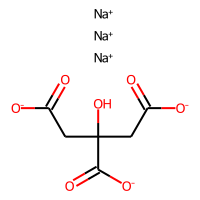
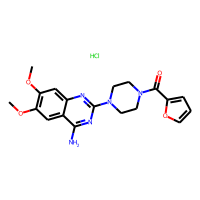

In [7]:
# Reseting the test cases
test_cases_df = pd.DataFrame.from_dict(test_cases)

# Creating mol objects from smiles (pre-cleaned)
PandasTools.AddMoleculeColumnToFrame(smilesCol='SMILES', molCol='RAW_MOL', frame=test_cases_df)
show_df(test_cases_df[['SMILES', 'RAW_MOL', 'CASE']].head(3))

,NAME,RAW_MOL,CLEAN_MOL,CASE
0,DEXTROAMPHETAMINE HYDROCHLORIDE,,,STEREOCHEMISTRY
1,SODIUM CITRATE,,,MULTIPLE SALT
2,PRAZOSIN HYDROCHLORIDE,,,SIMPLE SALT
3,CHLOROQUINE DIPHOSPHATE,,,COMPLEX SALT
4,DIMETHYL SULFOXIDE,,,POSITIVE/NEGATIVE
5,LACTATE,,,NEGATIVE
6,DECAMETHONIUM,,,POSITIVE
7,DIHYDROTESTOSTERONE,,,SINGLE
8,SACCHARIN,,,DOUBLE
9,BETACAROTENE,,,ALTERNATING DOUBLE

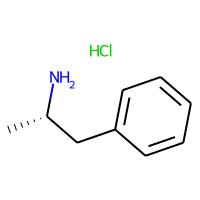
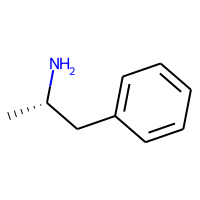
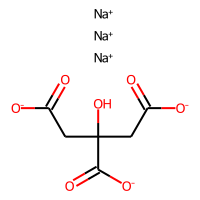
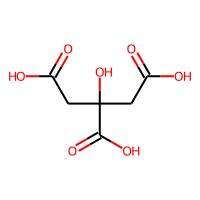
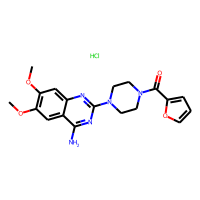
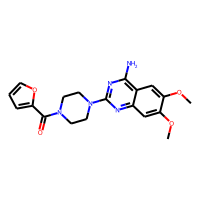
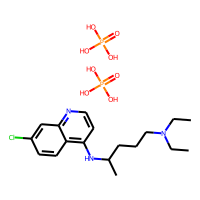
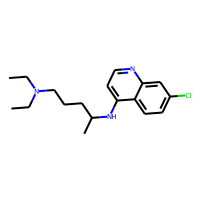
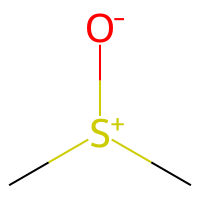
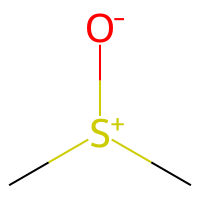
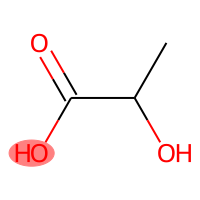
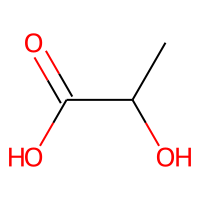
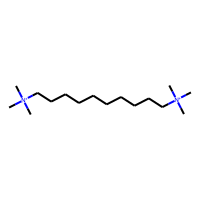
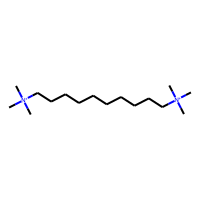
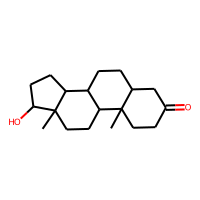
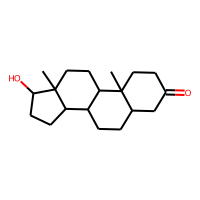
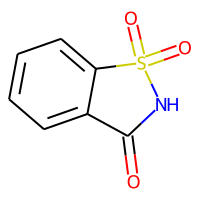
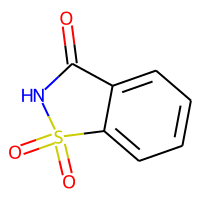
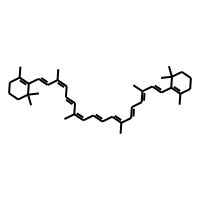
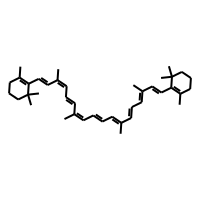
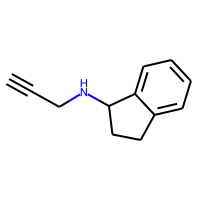
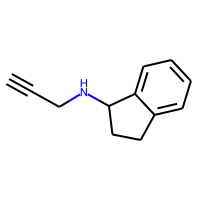
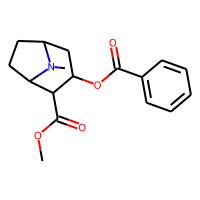
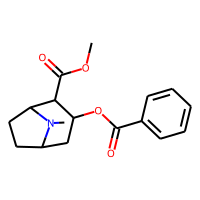
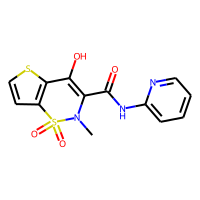
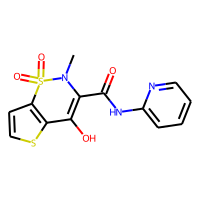
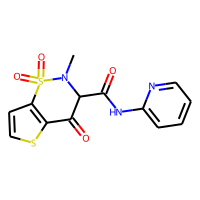
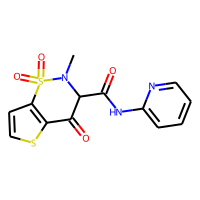
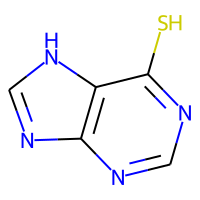
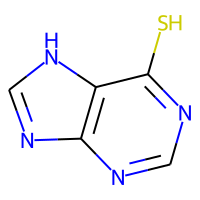

In [8]:
# Striping Mol from MOL format derived from dirt smiles
remover = SaltRemover()
test_cases_df['STRIP_SALT_MOL'] = test_cases_df['RAW_MOL'].apply(lambda x: remover.StripMol(x, dontRemoveEverything=True))

# Then Neutralizing the Strip_Salt and going back to SMILES
test_cases_df['CLEANED_SMILES'] = test_cases_df['STRIP_SALT_MOL'].apply(neutralize_standardize_atoms)

# Generating InchI from mol
test_cases_df['CLEAN_MOL'] = test_cases_df['CLEANED_SMILES'].apply(Chem.MolFromSmiles)
test_cases_df['INCHI'] = test_cases_df['CLEAN_MOL'].apply(Chem.MolToInchi)

# Dropping duplicated:
test_cases_df.drop_duplicates(subset=['INCHI'], keep='first', inplace=True)

show_df(test_cases_df[['NAME','RAW_MOL', 'CLEAN_MOL', 'CASE']])

The same output that our workflow has made, it may be even simpler for structures in other datasets; The only limitation is that keto-enolic structures are not identified as the same.

# <a id='toc5_'></a>[Creating the object to clean structures](#toc0_)

In [9]:
# Reseting the test cases
test_cases_df = pd.DataFrame.from_dict(test_cases)

In [10]:
class SmilesCleaner:
    """
    A class for cleaning and processing SMILES data in a DataFrame.
    """

    def __init__(self, dataframe):
        """
        Constructor for SmilesCleaner.

        Parameters:
            dataframe (pandas.DataFrame): The input DataFrame containing SMILES data.
        """
        self.df =  dataframe

    def strip_salt(self, smiles_col, output_col):
        """
        Strip salts from the molecules in the specified column.

        Parameters:
            smiles_col (str): Name of the column containing SMILES strings.
            output_col (str): Name of the column to store the stripped SMILES.

        Returns:
            SmilesCleaner: An instance of SmilesCleaner with the updated DataFrame.
        """
        self.remover = SaltRemover()
        # Create mol from raw_mol column and then strip its salt
        PandasTools.AddMoleculeColumnToFrame(smilesCol=smiles_col, molCol='raw_mol', frame=self.df)
        self.df['stripped_salt_mol'] = self.df['raw_mol'].apply(lambda x: self.remover.StripMol(x, dontRemoveEverything=True))

        # Create stripped salt smiles and drop mol column
        self.df[output_col] = self.df['stripped_salt_mol'].apply(Chem.MolToSmiles)
        self.df.drop(columns=['stripped_salt_mol', 'raw_mol'], axis=1, inplace=True) # drop stripped salt mol
        
        return self

        
    def neutralize(self, smiles_col, output_col):
        """
        Neutralize the molecules in the specified column.

        Parameters:
            smiles_col (str): Name of the column containing SMILES strings.
            output_col (str): Name of the column to store the neutralized SMILES.

        Returns:
            SmilesCleaner: An instance of SmilesCleaner with the updated DataFrame.
        """
        # Recreate the mol using the stripped salt smiles
        PandasTools.AddMoleculeColumnToFrame(smilesCol=smiles_col, molCol='stripped_salt_mol', frame=self.df)
        
        # Create the neutralized smiles column and return the its smiles
        self.df[output_col] = self.df['stripped_salt_mol'].apply(neutralize_standardize_atoms)
        self.df.drop(columns=['stripped_salt_mol'], axis=1, inplace=True)
        
        return self

    
    def search_duplicate(self, smiles_col, keep_inchi=False):
        # Dependendo da funcao, ja dropar
        """
        Drop duplicate molecules based on their SMILES or InChI.

        Parameters:
            smiles_col (str): Name of the column containing SMILES strings.
            keep_inchi (bool): Whether to keep the InChI column (default is False).

        Returns:
            SmilesCleaner: An instance of SmilesCleaner with the updated DataFrame.
        """
        PandasTools.AddMoleculeColumnToFrame(smilesCol=smiles_col, molCol='clean_mol', frame=self.df)
        self.df['inchi'] = self.df['clean_mol'].apply(Chem.MolToInchi)

        # now dropping the duplicates and signaling only duplicated
        self.df.drop(columns=['clean_mol'], axis=1, inplace=True)
        self.df['duplicated'] = self.df.duplicated(subset=['inchi'], keep=False)

        if not keep_inchi:
            self.df.drop(columns=['inchi'], axis=1, inplace=True)
            return self
        else:
            return self


In [12]:
# Improving
workflow = SmilesCleaner(test_cases_df)
stripped_salt = workflow.strip_salt(smiles_col='SMILES',output_col='smiles_stripped_salt')
neutral = stripped_salt.neutralize(smiles_col='smiles_stripped_salt', output_col='clean_smiles')
droped_duplicates = neutral.search_duplicate(smiles_col='clean_smiles', keep_inchi=False)

droped_duplicates.df[['SMILES', 'smiles_stripped_salt', 'clean_smiles', 'duplicated']]


,SMILES,smiles_stripped_salt,clean_smiles,duplicated
0,C[C@@H](CC1=CC=CC=C1)N.Cl,C[C@H](N)Cc1ccccc1,C[C@H](N)Cc1ccccc1,False
1,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O.[Na+].[N...,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-],O=C(O)CC(O)(CC(=O)O)C(=O)O,False
2,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=C...,COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC,COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC,False
3,CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl.OP(=O)(...,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,False
4,C[S+](C)[O-],C[S+](C)[O-],C[S+](C)[O-],False
5,CC(C(=O)[O-])O,CC(O)C(=O)[O-],CC(O)C(=O)O,False
6,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,False
7,CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C,CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O,CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O,False
8,C1=CC=C2C(=C1)C(=O)NS2(=O)=O,O=C1NS(=O)(=O)c2ccccc21,O=C1NS(=O)(=O)c2ccccc21,False
9,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,CC(C=CC=C(C)C=CC1=C(C)CCCC1(C)C)=CC=CC=C(C)C=C...,CC(C=CC=C(C)C=CC1=C(C)CCCC1(C)C)=CC=CC=C(C)C=C...,False
